In [3]:
import tensorflow as tf
import numpy as np
import os
import numpy as np 
import matplotlib.pyplot as plt
import glob
import shutil
import tensorflow_hub as hub

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [17]:
_URL = 'https://fire-net-datasets.s3.amazonaws.com/Training+Dataset.zip'

zip_file = tf.keras.utils.get_file(origin=_URL,extract=True,fname='Training Dataset',)   

505036800/505020699 [==============================] - 7s 0us/step


In [19]:
base_dir = os.path.join(os.path.dirname(zip_file), 'Training Dataset')
print(base_dir)

/root/.keras/datasets/Training Dataset


In [20]:
classes = ['Fire', 'NoFire']

In [21]:
for cl in classes:
  img_path = os.path.join(base_dir, cl)
  images = glob.glob(img_path + '/*.jpg')
  print("{}: {} Images".format(cl, len(images)))
  train, val = images[:round(len(images)*0.7)], images[round(len(images)*0.7):]

  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
      os.makedirs(os.path.join(base_dir, 'train', cl))
    shutil.move(t, os.path.join(base_dir, 'train', cl))

  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
      os.makedirs(os.path.join(base_dir, 'val', cl))
    shutil.move(v, os.path.join(base_dir, 'val', cl))

Fire: 1124 Images
NoFire: 1301 Images


In [22]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

In [23]:
batch_size = 50
IMG_SHAPE = 224

In [24]:
image_gen_train = ImageDataGenerator(rescale = 1./255,
                    zoom_range = 0.5,
                    rotation_range=45,
                    horizontal_flip=True,
                    width_shift_range=0.15,
                    height_shift_range=0.15,
                    shear_range=0.2)
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                            directory=train_dir,
                                            shuffle=True,
                                            target_size=(IMG_SHAPE,IMG_SHAPE),
                                            class_mode='binary')
print(train_data_gen.samples)
#Find our size of datasets. each

Found 1940 images belonging to 2 classes.
1940


In [25]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

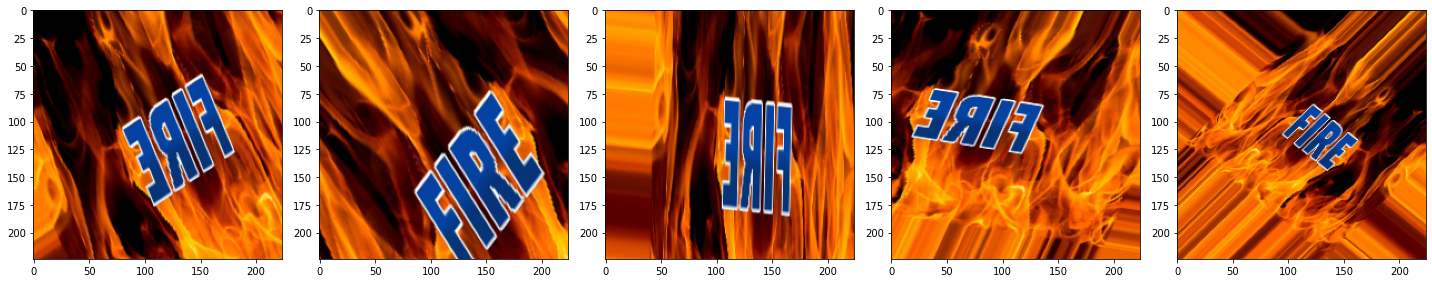

In [26]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [27]:
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                            directory=val_dir,
                            target_size=(IMG_SHAPE,IMG_SHAPE),
                            class_mode='binary')

Found 485 images belonging to 2 classes.


In [28]:
URL = 'https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5'
feature_extractor = hub.KerasLayer(URL, input_shape=(IMG_SHAPE,IMG_SHAPE,3))

In [29]:
feature_extractor.trainable=False

In [30]:
model = tf.keras.models.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(2,activation=tf.nn.softmax)
])

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [32]:
EPOCHS = 10
model.compile(optimizer="adam",
                loss=tf.keras.losses.sparse_categorical_crossentropy,
                metrics=['accuracy'])

history = model.fit(train_data_gen,epochs= EPOCHS,
                validation_data = val_data_gen)

Epoch 1/10
Extension horovod.torch has not been built: /usr/local/lib/python3.8/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-38-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.
[2022-03-25 17:54:48.296 tensorflow-2-6-gpu-py-ml-t3-medium-2e2c7c0afde0c32682030cb02477:95 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-03-25 17:54:48.360 tensorflow-2-6-gpu-py-ml-t3-medium-2e2c7c0afde0c32682030cb02477:95 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
39/39 [==============================] - 124s 3s/step - loss: 0.3513 - accuracy: 0.8407 - val_loss: 0.2293 - val_accuracy: 0.9031
Epoch 2/10
39/39 [==============================] - 116s 3s/step - loss: 0.1960 - accuracy: 0.9232 - val_loss: 0.2364 - val_accuracy: 0.9072
Epoch 3/10
39/39 [==========

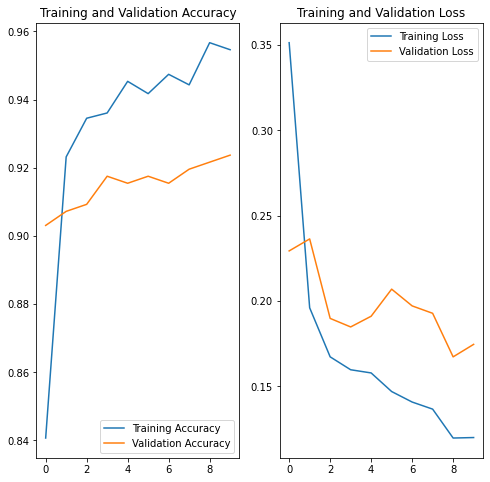

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
